# Figure 4: site acquired by AL

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split


#import * from utils, gaussian_process, active_learner in ../src
import sys
sys.path.append('../src')
from utils import *
from gaussian_process import *
from active_learner import *
from hist_al import *

In [2]:
df, X_df, y, targets = load_and_preprocess_data('esm3_coord', 'bloom')

df.site_SARS2.unique()
#find numbers in range 334 to 526 that are not in the site_SARS2 column
missing = np.array([i for i in range(331, 532) if i not in df.site_SARS2.unique()])
#remove 331 to all values
missing -=331
missing

e:\VIRAL\plots\../src\utils.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(file_path)  # Load the tensor


loaded embeddings of shape torch.Size([3803, 1536])


array([  0,   1,   2,  12,  19,  24,  33,  48,  67,  69,  81,  85,  91,
        92,  95, 100, 101, 105, 111, 123, 126, 136, 149, 157, 160, 164,
       166, 171, 178, 180, 192, 196, 197, 198, 199, 200])

# Biology analysis of sites acquired by AL

In [3]:
import os


#MLP
base_path_ucb = "../script_results/hist_al_bloom_esm3_coord/training_set_UCB_run_{}.csv"
base_path_greedy = "../script_results/hist_al_bloom_esm3_coord/training_set_greedy_run_{}.csv"
base_path_ace2 = "../script_results/ace2_hist_al_esm3_coord/training_set_UCB_run_{}.csv"
base_path_direct2020 = "../script_results/1_batch_real_direct_esm3_coord/training_set_bloom_1000_date1.csv"
#2021 and not 2022 here
base_path_direct2022 = "../script_results/1_batch_real_direct_esm3_coord/training_set_bloom_1000_date5.csv"
# Initialize dictionary to store results
def get_site_cout_dict(path):
    site_counts_dict = {}

    # Loop over runs 0 to 9
    for run in range(10):
        file_path = path.format(run)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            # Compute counts for sites between 331 and 531
            site_counts = (
                df['site_SARS2']
                .value_counts()
                .reindex(range(331, 532), fill_value=0)
                .sort_index()
            )

            site_counts_dict[f'run_{run}'] = site_counts.values
        else:
            print('not found')
            site_counts_dict[f'run_{run}'] = np.zeros(201)
    return site_counts_dict

def get_site_cout_dict_1_batch(file_path):
    site_counts_dict = {}

    # Loop over runs 0 to 9
    for run in range(10):
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            # Compute counts for sites between 331 and 531
            site_counts = (
                df['site_SARS2']
                .value_counts()
                .reindex(range(331, 532), fill_value=0)
                .sort_index()
            )
            site_counts_dict[f'run_{run}'] = site_counts.values
        else:
            print('not found')
            site_counts_dict[f'run_{run}'] = np.zeros(201)
    
    return site_counts_dict
site_counts_dict_ucb=get_site_cout_dict(base_path_ucb)
site_counts_dict_greedy=get_site_cout_dict(base_path_greedy)
site_counts_dict_ace2=get_site_cout_dict(base_path_ace2)
# site_counts_dict_direct2020=get_site_cout_dict(base_path_direct2020)
# site_counts_dict_direct2021=get_site_cout_dict(base_path_direct2021)
site_counts_dict_direct2020=get_site_cout_dict_1_batch(base_path_direct2020)
site_counts_dict_direct2022=get_site_cout_dict_1_batch(base_path_direct2022)
site_counts_dict_ucb


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


{'run_0': array([ 0,  0,  0,  2,  7, 19, 19,  3,  4, 19,  4,  2,  0,  1,  5,  3,  1,
         3,  1,  0,  1,  1,  2,  2,  0, 15,  2, 10,  1,  3, 19,  3,  1,  0,
        11,  2,  4,  4,  2,  4,  4,  9,  2,  5,  2,  3,  3,  3,  0,  1,  1,
         1,  4,  6,  5,  6,  2,  1,  5,  2, 14,  3,  1,  2,  2,  2,  4,  0,
         3,  0,  1,  2,  2,  1,  6,  7,  2,  3,  2,  1,  1,  0,  1,  5,  3,
         0,  6,  1,  1,  3,  1,  0,  0,  2,  1,  0,  2,  2,  2,  2,  0,  0,
         1,  5,  2,  0,  2,  1,  1,  5,  6,  0,  1,  7, 13,  7,  1,  4,  1,
         4,  1,  6,  1,  0,  3,  1,  0,  2,  2,  2,  2,  2,  2,  1,  9,  1,
         0,  5,  1,  3, 10,  2,  2,  1,  4,  3,  4,  6,  6,  0,  3,  3, 16,
        17,  9,  8,  2,  0,  1,  4,  0,  1,  7,  4,  0,  3,  0,  3, 10,  5,
         1,  0,  7,  5,  1,  2, 13,  3,  0,  1,  0,  1,  3,  4,  3, 14,  2,
         5,  6,  1,  7,  1,  0,  2,  3,  5,  0,  0,  0,  0,  0],
       dtype=int64),
 'run_1': array([ 0,  0,  0,  3,  5, 19, 19,  2,  4, 18,  3,  2,  0, 

# Comparison with gisaid data

In [5]:
rbd_df=pd.read_csv('../gisaid/rbd_dates.csv', sep=',')
rbd_df

,seq,count,q05_date
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,3980832,2021-06-29 00:00:00
1,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...,1297376,2022-01-31 00:00:00
2,NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...,1219498,2022-06-11 00:00:00
3,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1094468,2021-01-18 00:00:00
4,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,816046,2020-03-26 00:00:00
...,...,...,...
25720,NITNLCPFDEVFNATTFASVYAWNRKRISNCVADYSVLYNFAPFFA...,1,2023-01-02 00:00:00
25721,NITNLCPFDEVFNATTFASVYAWNRKRISNCVADYSVLYNFAPFFA...,1,2023-01-12 00:00:00
25722,NITNLCPFDEVFNATTFASVYAWNRKRISNCVADYSVLYNFAPFFA...,1,2022-10-19 00:00:00
25723,NITNLCPFDEVFNATTFASVYAWNRKRISNCVADYSVLYNFAPFFA...,1,2022-10-31 00:00:00


Position 0: {'N', 'H', 'Y', 'K', 'T', 'S'}
Position 1: {'A', 'V', 'I', 'T', 'S'}
Position 2: {'K', 'I', 'A', 'T'}
Position 3: {'Y', 'H', 'N', 'K', 'S'}
Position 4: {'V', 'F', 'S', 'L'}
Position 5: {'C'}
Position 6: {'H', 'R', 'P', 'T', 'S', 'L'}
Position 7: {'L', 'Y', 'F'}
Position 8: {'N', 'H', 'Y', 'R', 'D', 'A', 'E', 'V', 'C', 'G', 'S', 'L'}
Position 9: {'A', 'E', 'D', 'K', 'Q', 'V', 'G'}
Position 10: {'V', 'I', 'L'}
Position 11: {'Y', 'F', 'I', 'S', 'L'}
Position 12: {'N', 'T'}
Position 13: {'A', 'D', 'V', 'I', 'G', 'T', 'C', 'S'}
Position 14: {'N', 'P', 'T', 'S', 'L'}
Position 15: {'R', 'E', 'K', 'Q', 'I', 'G', 'T', 'S'}
Position 16: {'V', 'G', 'R', 'F'}
Position 17: {'A', 'E', 'Q', 'V', 'P', 'T', 'S'}
Position 18: {'A', 'V', 'G', 'P', 'T', 'S'}
Position 19: {'V', 'I', 'A', 'L'}
Position 20: {'L', 'Y', 'H', 'I', 'F'}
Position 21: {'A', 'N', 'D', 'V', 'G', 'T', 'S'}
Position 22: {'L', 'Y', 'E', 'W', 'F'}
Position 23: {'N', 'H', 'R', 'Y', 'D', 'K', 'T', 'S'}
Position 24: {'S', 'N', 

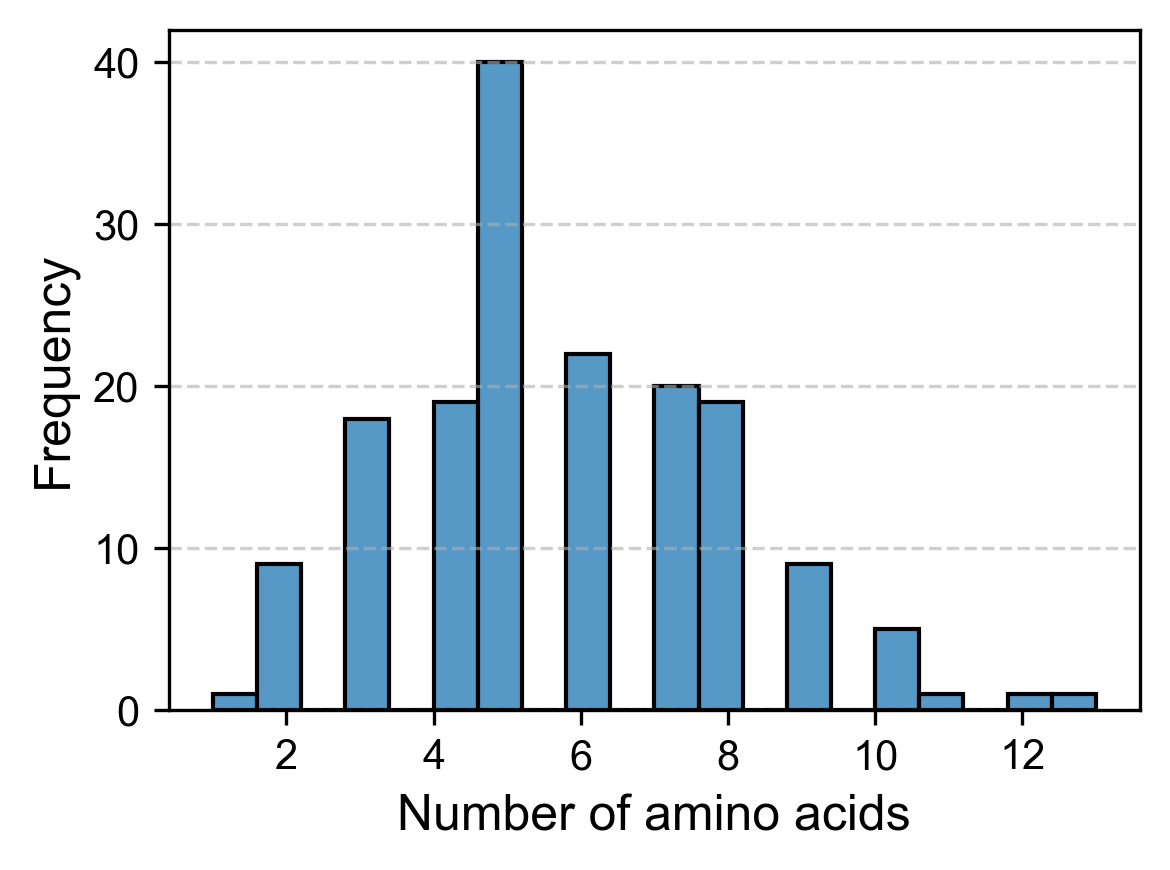

In [6]:
import pandas as pd

def get_unique_characters_at_positions(df):
    # Initialize an empty dictionary to store sets of characters for each position
    position_dict = {}

    # Iterate through each sequence in the 'seq' column
    for row in df.iterrows():
            seq=row[1]['seq']
            count=row[1]['count']
            #check count>0
            if count<10:
                 continue
                # Iterate through each character in the sequence
        
            for position, char in enumerate(seq):
                # If position is not in the dictionary, create a new set
                if position not in position_dict:
                    position_dict[position] = set()
                # Add the character to the set at that position
                position_dict[position].add(char)

    return position_dict

# Example usage:
# Assuming 'rdb_df' is your dataframe
rbd_variations = get_unique_characters_at_positions(rbd_df)

# Printing the result and store nb of variations per position
variations_array=[]
for position, characters in rbd_variations.items():
    print(f"Position {position}: {characters}")
    variations_array.append(len(characters))

variations_array=np.array(variations_array)
variations_array=np.delete(variations_array, missing)

#only indexees in site_rbd_list_index
print(variations_array)
#histogram of variations_array

plt.figure(figsize=(4, 3), dpi=300)

sns.histplot(variations_array, bins=20, kde=False)

plt.xlabel("Number of amino acids", fontsize=12, fontname="Arial")
plt.ylabel("Frequency", fontsize=12, fontname="Arial")
plt.xticks(fontsize=10, fontname="Arial")
plt.yticks(fontsize=10, fontname="Arial")

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the figure in vector format
plt.savefig("../figures/variations_histogram.png", dpi=300, bbox_inches="tight")
plt.show()


In [7]:
th=8

In [8]:
#binary array of 1 if variation, 0 if no variatio>12
binary_variations_array=variations_array>th
#delete indexes in missing
print(binary_variations_array)
#with 1 or 0
binary_variations_array=binary_variations_array.astype(int)
#percentgae of variation
print(sum(binary_variations_array)/len(binary_variations_array))
print(binary_variations_array.shape)

[False False False False False  True False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False  True False False
 False  True False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False  True False False  True False
  True False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False  True  True  True False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False Fa

# UCB

auc run 0.7812003179650239
auc run 0.7587440381558029
auc run 0.656597774244833
auc run 0.5759141494435612
auc run 0.6826311605723371
auc run 0.714825119236884
auc run 0.621422893481717
auc run 0.682631160572337
auc run 0.6381160572337043
auc run 0.7460254372019078
top indexes
[333 355 334 337 486 461 460 352 472 479 350 426 444 449 433 463 383 457
 468 462 365 395 491 378 376 488 358 450 422 425 423 427 429]


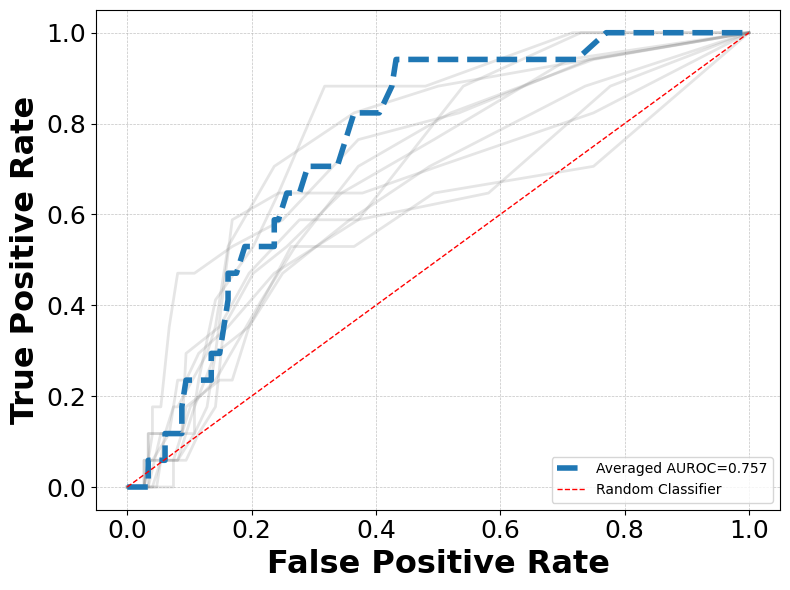

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming binary_variations_array is defined
binary_variations_array = variations_array > th

# Initialize the plot
plt.figure(figsize=(8, 6))

# Iterate over the dictionary
score=np.zeros(binary_variations_array.shape[0])
for run, hist_u in site_counts_dict_ucb.items():
    if hist_u is not None:  # Skip runs without data
        #delete indexes in missing
        hist_u=np.delete(hist_u, missing)
        # Calculate FPR, TPR, and AUC for the current run
        fpr_u, tpr_u, _ = roc_curve(binary_variations_array, hist_u)
        roc_auc = auc(fpr_u, tpr_u)
        print('auc run', roc_auc)
        score+=hist_u
        
        # Plot ROC curve for the current run
        plt.plot(fpr_u, tpr_u, linestyle='-', linewidth=2, alpha=0.2, color='grey'
                 )
        
top_10_percent = int(len(score) * 0.2)

# Get the indexes of the largest 10% numbers
top_indexes = np.argsort(score)[-top_10_percent:]

# If you want the indexes in descending order (largest to smallest value)
top_indexes = top_indexes[np.argsort(score[top_indexes])[::-1]]
print('top indexes')
print(top_indexes+331)
fpr_u, tpr_u, _ = roc_curve(binary_variations_array, score)
roc_auc = auc(fpr_u, tpr_u)
# Plot ROC curve for the current run
plt.plot(fpr_u, tpr_u, linestyle='--', linewidth=4, 
        label=f'Averaged AUROC={roc_auc:.3f}')
        


# Add reference line for random classifier
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1, label='Random Classifier')

# Add labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=23, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=23, fontweight='bold')
# plt.title('ROC Curves for Different Runs, UCB', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')

# Add grid and styling
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.75)

plt.tight_layout()  # Adjust layout to avoid clipping
plt.savefig(f'../figures/roc_curves_ucb.png', dpi=1200, bbox_inches='tight')

plt.show()


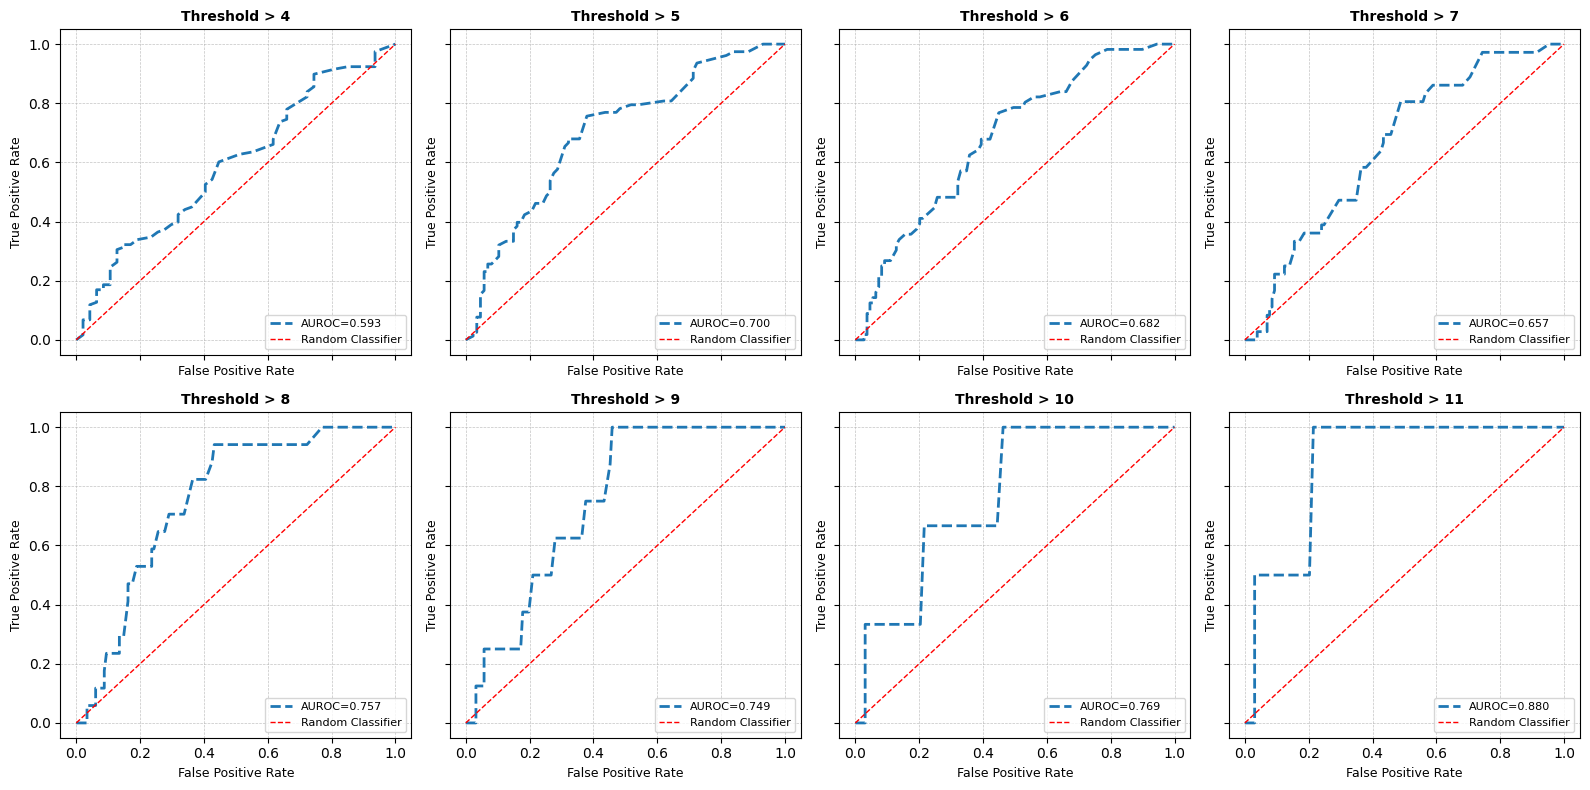

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming variations_array and site_counts_dict_ucb are defined

# Define the thresholds for subplots
thresholds = range(4, 12)

# Create subplots (2 rows and 4 columns for thresholds 7-14)
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten axes for easy iteration

for i, threshold in enumerate(thresholds):
    # Calculate binary variations for the current threshold
    binary_variations_array = variations_array > threshold

    # Accumulate scores for average ROC
    score = np.zeros(binary_variations_array.shape[0])
    for run, hist_u in site_counts_dict_ucb.items():
        if hist_u is not None:
            hist_u = np.delete(hist_u, missing)
            score += hist_u

    # Compute ROC curve and AUROC for the average score
    fpr, tpr, _ = roc_curve(binary_variations_array, score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for the current threshold
    ax = axes[i]
    ax.plot(fpr, tpr, linestyle='--', linewidth=2, label=f'AUROC={roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1, label='Random Classifier')

    # Add labels and title to the subplot
    ax.set_title(f'Threshold > {threshold}', fontsize=10, fontweight='bold')
    ax.set_xlabel('False Positive Rate', fontsize=9)
    ax.set_ylabel('True Positive Rate', fontsize=9)
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.75)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(f'../figures/all_roc_curves_ucb.png', dpi=1200, bbox_inches='tight')

plt.show()


## Benchmark other methods

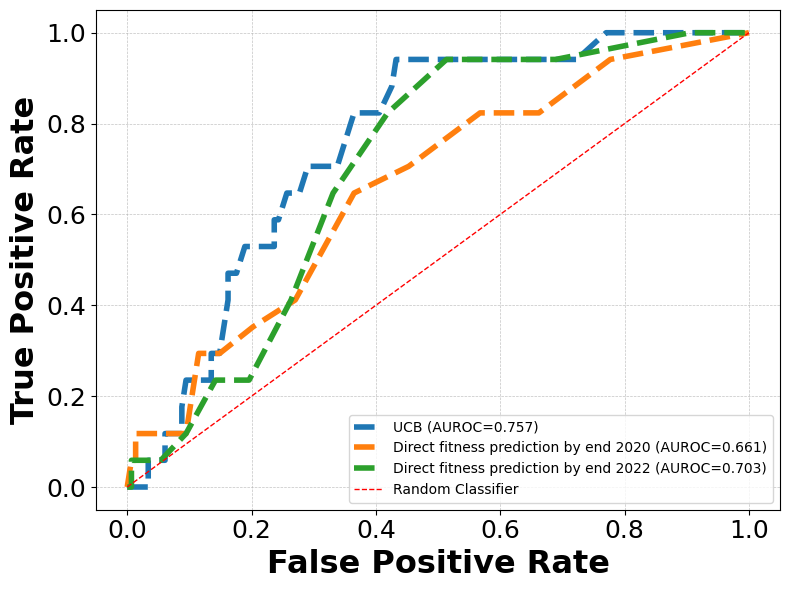

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming binary_variations_array and dictionaries are defined
binary_variations_array = variations_array > th

# Define methods and corresponding data dictionaries
methods = {
    "UCB": site_counts_dict_ucb,
    # "Greedy": site_counts_dict_greedy,
    # "ACE2": site_counts_dict_ace2,
    "Direct fitness prediction by end 2020": site_counts_dict_direct2020,
    "Direct fitness prediction by end 2022": site_counts_dict_direct2022

}

# Initialize the plot
plt.figure(figsize=(8, 6))

# Iterate over each method
for method_name, data_dict in methods.items():
    score = np.zeros(binary_variations_array.shape[0])
    
    # Accumulate scores for each run
    for run, hist_u in data_dict.items():
        if hist_u is not None:
            hist_u = np.delete(hist_u, missing)
            score += hist_u

    # Calculate average ROC curve and AUROC
    fpr_u, tpr_u, _ = roc_curve(binary_variations_array, score)
    roc_auc = auc(fpr_u, tpr_u)
    
    # Plot the averaged ROC curve for the current method
    plt.plot(fpr_u, tpr_u, linestyle='--', linewidth=4, label=f'{method_name} (AUROC={roc_auc:.3f})')

# Add reference line for random classifier
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1, label='Random Classifier')

# Add labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=23, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=23, fontweight='bold')
# plt.title('Average ROC Curves for site acquisition', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')

# Add grid and styling
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.75)

plt.tight_layout()  # Adjust layout to avoid clipping
plt.savefig(f'../figures/roc_curves_models.png', dpi=1200, bbox_inches='tight')

plt.show()


# Sites

In [12]:
ba1_sites=[339,371,373,375,417,440,446,477,478,484,493,496,498,501,505]
hot_sites = [376,405,408,490] #https://pmc.ncbi.nlm.nih.gov/articles/PMC9266794/
ba_3_sites=[]
# hot_sites=[346,452,486, 450, 490,376,405,408,452,486,]

In [13]:
score=np.zeros(201)
for run, hist_u in site_counts_dict_ucb.items():
    if hist_u is not None:  # Skip runs without data
        score+=hist_u
        

score.shape

(201,)

In [14]:
# Create the DataFrame
site_sampled_counts = pd.DataFrame({
    'count': score,
    'site_SARS2': np.arange(331, 331 + len(score))
})
filtered_df = site_sampled_counts[site_sampled_counts['site_SARS2'].isin(ba1_sites + hot_sites)]
filtered_df.loc[:, 'sampled_AA'] = filtered_df['count'] / 10
filtered_df

C:\Users\maria\AppData\Local\Temp\ipykernel_18416\1903849298.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'sampled_AA'] = filtered_df['count'] / 10


,count,site_SARS2,sampled_AA
8,53.0,339,5.3
40,35.0,371,3.5
42,23.0,373,2.3
44,30.0,375,3.0
45,27.0,376,2.7
74,68.0,405,6.8
77,35.0,408,3.5
86,31.0,417,3.1
109,58.0,440,5.8
115,56.0,446,5.6


In [15]:
sorted_site_sampled_counts = site_sampled_counts.sort_values(by='count', ascending=False)
top_30_counts = sorted_site_sampled_counts.head(20)
# print(top_30_counts)
top_30_counts['site_SARS2'].tolist()

[361,
 336,
 337,
 340,
 516,
 484,
 483,
 499,
 358,
 507,
 356,
 445,
 465,
 471,
 452,
 486,
 479,
 391,
 485,
 493]

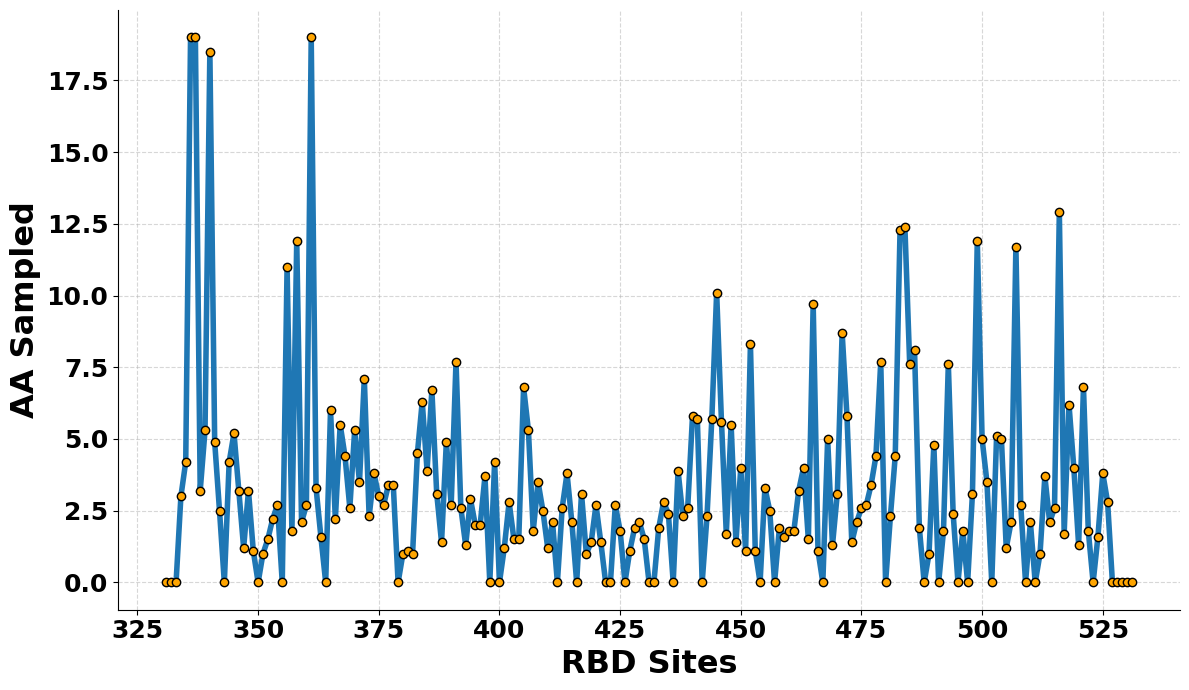

In [17]:
import matplotlib.pyplot as plt

# Setting up the plot for publication quality
plt.figure(figsize=(12, 7))  # Slightly larger figure for clarity

# Plotting with enhanced line thickness and color
plt.plot(
    site_sampled_counts['site_SARS2'], 
    site_sampled_counts['count'] / 10, 
    linewidth=4,  # Thicker line
    color='#1f77b4',  # Nice blue color
    marker='o',  # Add circular markers
    markersize=6,  # Marker size
    markerfacecolor='orange',  # Fill markers with a contrasting color
    markeredgecolor='black',  # Black border for markers
    label='Site Sampled Counts'
)

# Enhancing the plot for publication
plt.xlabel('RBD Sites', fontsize=23, fontweight='bold')
plt.ylabel('AA Sampled', fontsize=23, fontweight='bold')

# Adding subtle grid with better style
plt.grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.5)

# Customizing ticks
plt.xticks(fontsize=18,fontweight='bold')
plt.yticks(fontsize=18,fontweight='bold')
# Removing top and right spines for a cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Optional: Adding legend
# plt.legend(fontsize=18, loc='upper left')

# Tight layout for better spacing
plt.tight_layout()

# Saving the plot with high DPI for publication
plt.savefig('../figures/site_sample_counts.png', dpi=1200, bbox_inches='tight')

# Display the plot
plt.show()

# Site biology

In [24]:
df_bloom, train_x_bloom, train_y_bloom, targets_bloom = load_and_preprocess_data('esm2')
# interesting_sites=[339, 405, 484, 490 , 498]
interesting_sites = top_30_counts['site_SARS2'].tolist()

df_bloom.columns


df_bloom['site_SARS2'] = df_bloom['site_SARS2'].astype(int)



e:\VIRAL\plots\../src\utils.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(file_path)  # Load the tensor


loaded embeddings of shape torch.Size([3803, 1280])


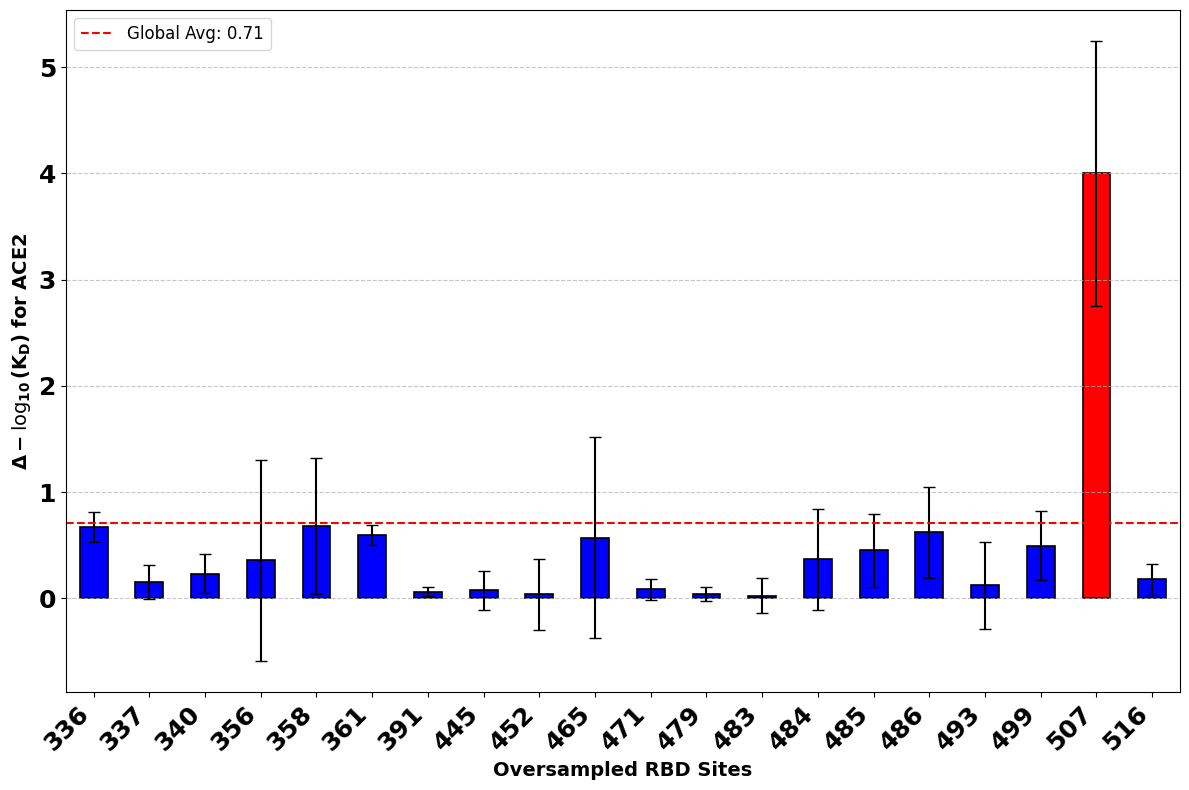

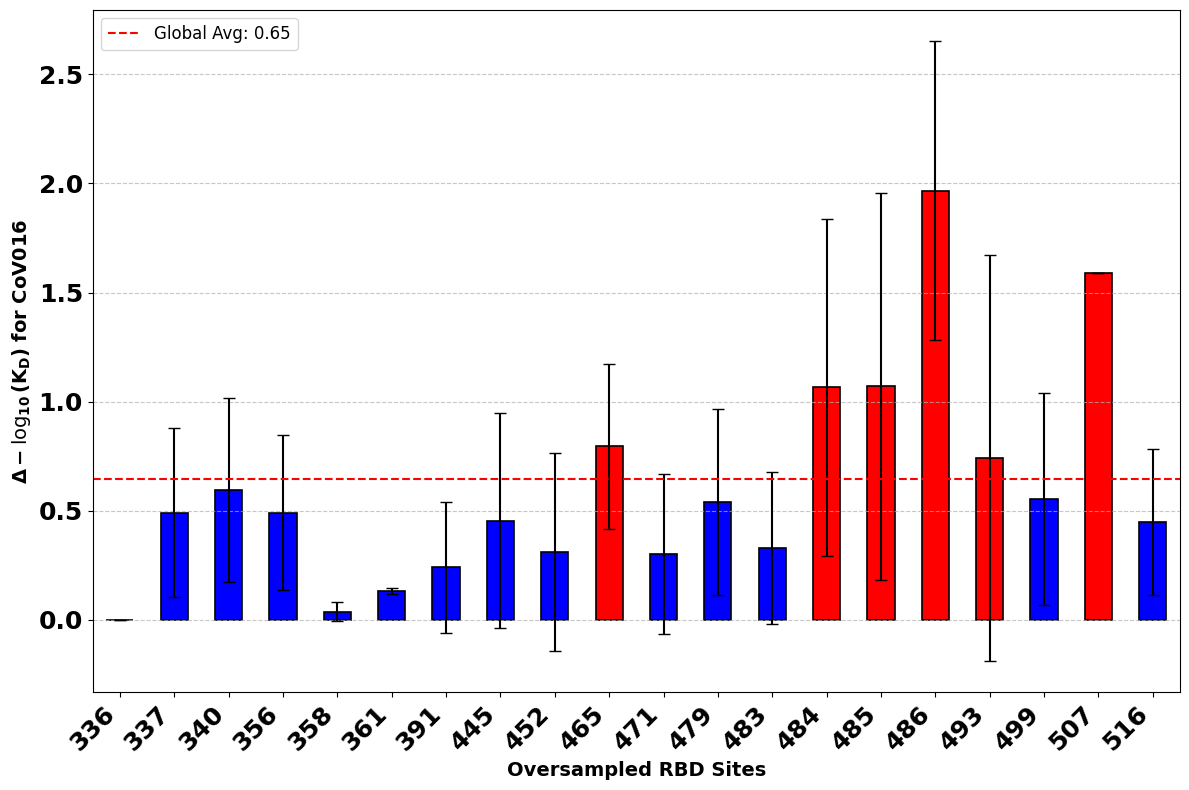

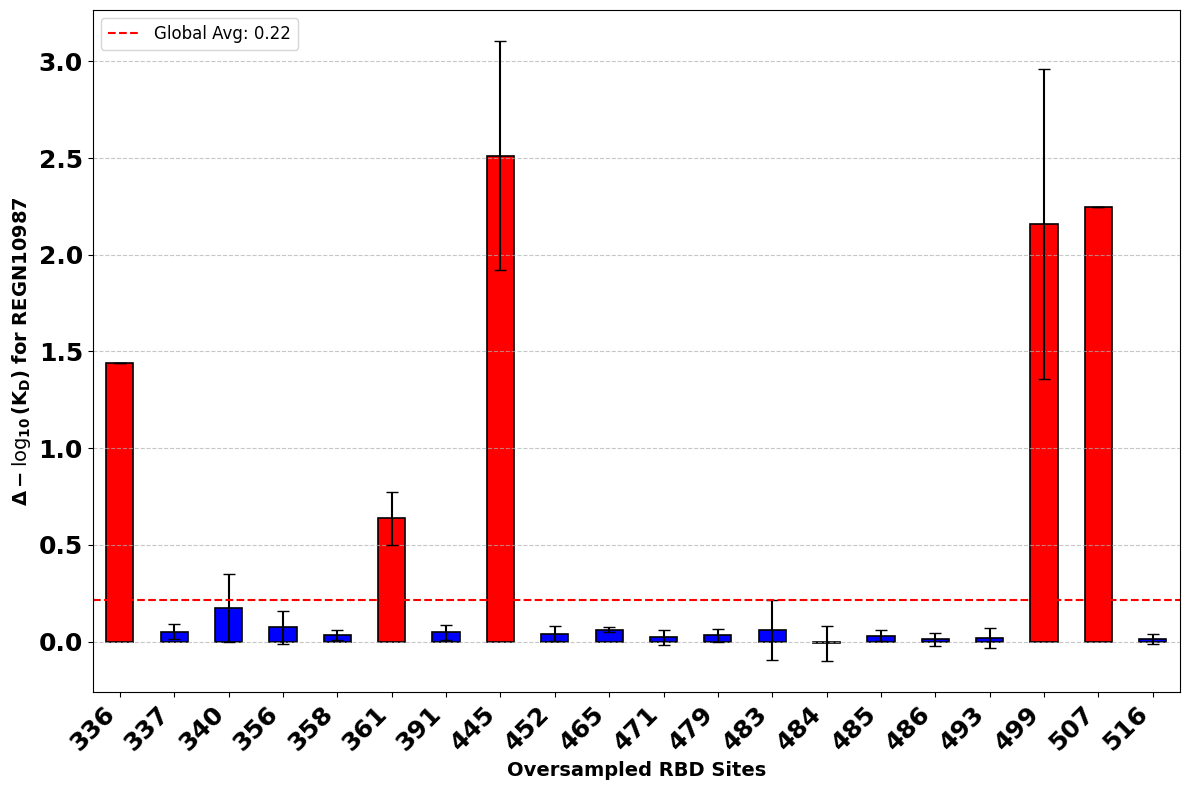

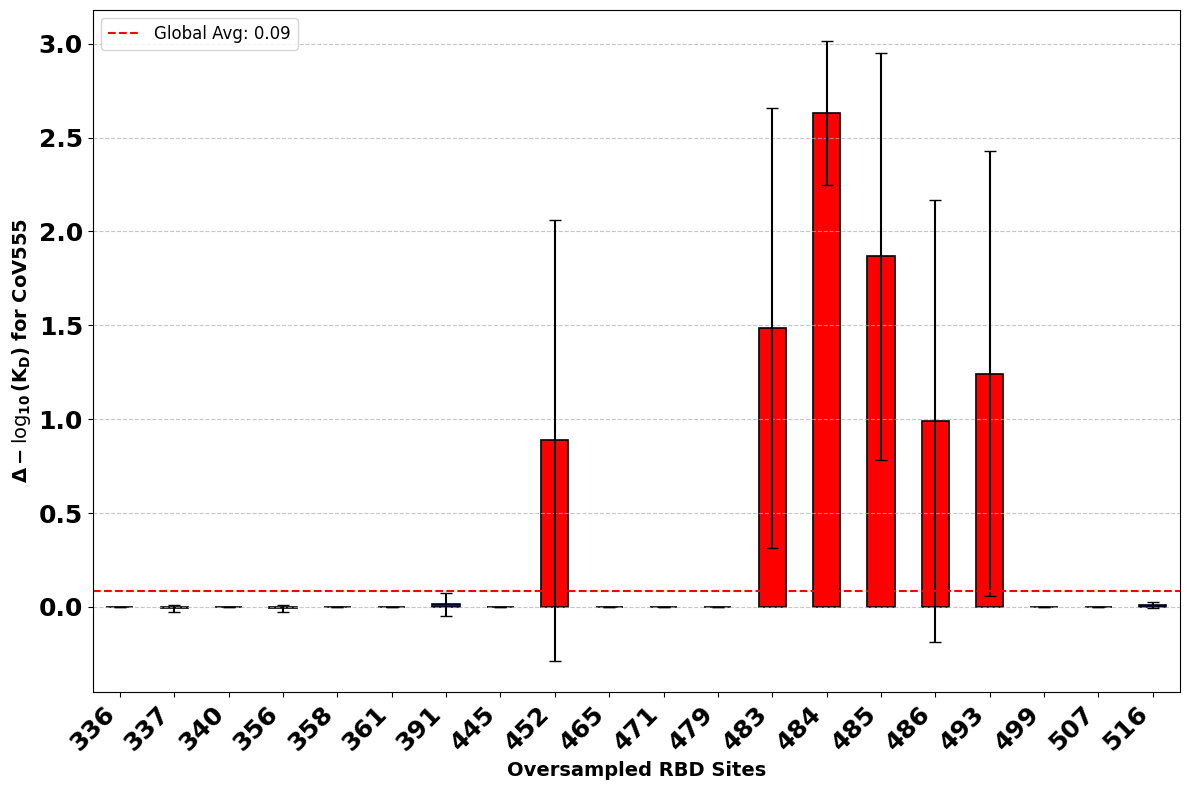

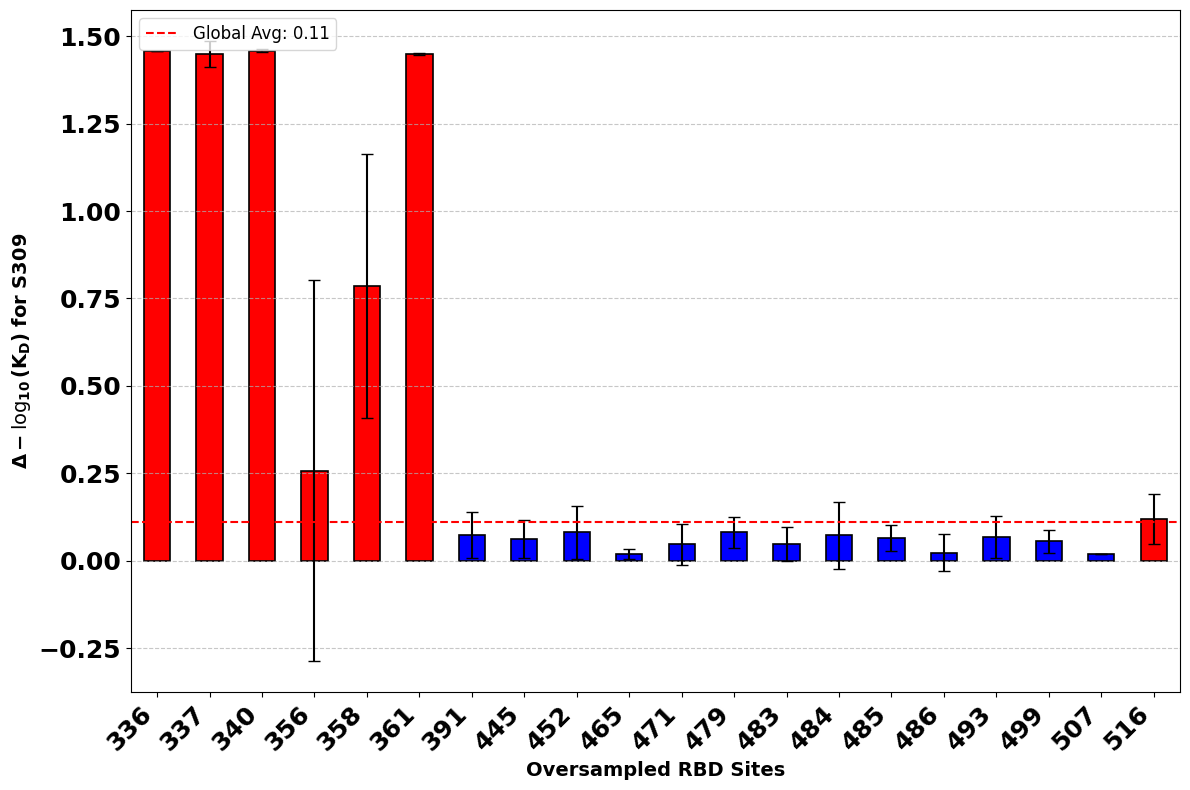

In [25]:
import matplotlib.pyplot as plt

# Filter data for interesting sites
filtered_df = df_bloom[df_bloom['site_SARS2'].isin(interesting_sites)]

# Antibodies of interest
antibodies = [
    'delta_log_kd_ACE2', 
    'delta_log_kd_LY-CoV016', 
    'delta_log_kd_REGN10987', 
    'delta_log_kd_LY-CoV555', 
    'delta_log_kd_S309'
]
antibody_names = ['ACE2', 'CoV016', 'REGN10987', 'CoV555', 'S309']
# Plot each antibody separately
for antibody, antibody_name in zip(antibodies, antibody_names):    # Create a new figure for each antibody
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Group data by site
    grouped = filtered_df.groupby('site_SARS2')[antibody].agg(['mean', 'std'])
    
    # Define bar colors based on whether the mean is above the global average
    global_avg = df_bloom[antibody].mean()
    colors = ['red' if mean > global_avg else 'blue' for mean in grouped['mean']]
    
    # Bar plot with error bars
    bars = grouped['mean'].plot(
        kind='bar', 
        yerr=grouped['std'], 
        ax=ax, 
        capsize=4, 
        color=colors, 
        edgecolor='black', 
        linewidth=1.2,
        label="_nolegend_" 
        
    )
    
    # Add a dashed horizontal line for the global average
    ax.axhline(global_avg, color='red', linestyle='--', linewidth=1.5, label=f'Global Avg: {global_avg:.2f}')
    
    # Customizations for appearance
    # ax.set_title(f'Effect of Mutations on {antibody}', fontsize=18, fontweight='bold')
    ax.set_xlabel('Oversampled RBD Sites', fontsize=14, fontweight='bold')

    # ax.set_ylabel(rf'$\Delta -\log_{{10}}K_D{antibody_name}$', fontsize=14, fontweight='bold')
    ax.set_ylabel(rf'$\mathbf{{\Delta -\log_{{10}}(K_D)\ for\ {antibody_name}}}$', fontsize=14)  # Bold LaTeX

    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=12, loc='upper left')
    plt.xticks(fontsize=18,rotation=45, ha='right',fontweight='bold')  # Rotate x-tick labels for readability
    plt.yticks(fontsize=18,fontweight='bold')
    # Grid styling
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Tight layout and saving the figure
    plt.tight_layout()
    plt.savefig(f'../figures/{antibody}_site_mut_effect.png', dpi=1200, bbox_inches='tight')
    plt.show()